# Few-shot learning - Omniglot - Fellowship.ai
This notebook is my personal project to the few-shot learning challenge from [Fellowship.ai](https://fellowship.ai/challenge/) with the following goal:
> Omniglot, the “transpose” of MNIST, with 1623 character classes, each with 20 examples.  Build a few-shot classifier with a target of <35% error.

I managed to reach an error rate of 6.5% on a 20-way classification corresponding to the current state of the art model.

# Abstract


### The Omniglot dataset
*Dataset reference:* [Link](https://github.com/brendenlake/omniglot)
> Lake, B. M., Salakhutdinov, R., and Tenenbaum, J. B. (2015). Human-level concept learning through probabilistic program induction. Science, 350(6266), 1332-1338.

The Omniglot dataset is often considered as the transpose of the MNIST dataset. While the latter contains only 10 classes with a training set of 60000 examples, Omniglot contains an important number of classes (1623 different handwritten characters from 50 different alphabets) with only a low number of examples (20) for each, making it an ideal dataset for few-shot learning problems.

### Few-shot learning
Whereas, lots of deep learning projects are based on a huge number of training examples to be trained, few-shot learning is  based only on a few one. This approach is much closer to the one experienced by humans. We are able to memorize and recognize objects we have never seen before from a few number of examples. Then for each new encounter with these types of object we can classify them in an accurate and easy way.

### Approach
The approach I used for this challenge is essentially based on a triplet-loss model.
For each image one embedding of size 64 was created using a ResNet-like architecture (current state of the art CNN architecture) combined to a triplet-loss  model.

# Content
* A/ Libraries and Images Path

* B/ Exploratory Data Analysis

* C/ Preprocessing

* D/ Triplet loss Neural Network Architecture

* E/ Training Procedure

* F/ Model Evaluation

## A/ Libraries and Images Path

#### Import useful libraries

In [5]:
import os
import glob

import tensorflow as tf
import numpy as np
from keras.models import Model, load_model
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, concatenate,AveragePooling2D, Lambda, Add
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import regularizers
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize
import h5py

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### PATH

We indicate the PATH of the training and evaluation examples.

In [17]:
PATH="images_background/" #Training images path

PATH_TEST = "images_evaluation/" #Validation and test images path

The pictures are divided into two folders :
The evaluation folder 

## B/ Exploratory Data Analysis

We have a look at the list of all alphabets contained in the training set, and their total number.
### 0.Alphabets in Training and Evaluation set
#### a) Traning set

In [7]:
alph_type = np.array(os.listdir(PATH)) #Give the different types of alphabet in our training data
print(f"List of the different alphabets:\n {alph_type}")
print(f"\nNumber of different alphabets: {len(alph_type)}")

List of the different alphabets:
 ['Alphabet_of_the_Magi' 'Anglo-Saxon_Futhorc' 'Arcadian' 'Armenian'
 'Asomtavruli_(Georgian)' 'Balinese' 'Bengali'
 'Blackfoot_(Canadian_Aboriginal_Syllabics)' 'Braille' 'Burmese_(Myanmar)'
 'Cyrillic' 'Early_Aramaic' 'Futurama' 'Grantha' 'Greek' 'Gujarati'
 'Hebrew' 'Inuktitut_(Canadian_Aboriginal_Syllabics)'
 'Japanese_(hiragana)' 'Japanese_(katakana)' 'Korean' 'Latin'
 'Malay_(Jawi_-_Arabic)' 'Mkhedruli_(Georgian)' 'N_Ko'
 'Ojibwe_(Canadian_Aboriginal_Syllabics)' 'Sanskrit' 'Syriac_(Estrangelo)'
 'Tagalog' 'Tifinagh']

Number of different alphabets: 30


#### b) Evaluation set

In [9]:
alph_type_test = np.array(os.listdir(PATH_TEST)) #Give the different types of alphabet in our evaluation data
print(f"List of the different alphabets:\n {alph_type_test}")
print(f"\nNumber of different alphabets: {len(alph_type_test)}")

List of the different alphabets:
 ['Angelic' 'Atemayar_Qelisayer' 'Atlantean' 'Aurek-Besh' 'Avesta' 'Ge_ez'
 'Glagolitic' 'Gurmukhi' 'Kannada' 'Keble' 'Malayalam' 'Manipuri'
 'Mongolian' 'Old_Church_Slavonic_(Cyrillic)' 'Oriya' 'Sylheti'
 'Syriac_(Serto)' 'Tengwar' 'Tibetan' 'ULOG']

Number of different alphabets: 20


### 1.Number of characters per alphabets
We then check the number of character for each alphabets.
#### a) Traning set

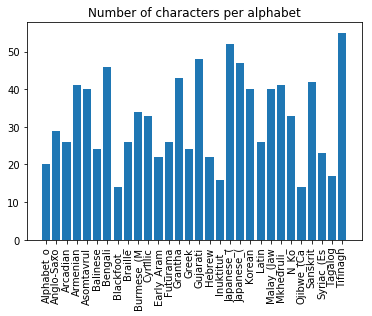


The maximum number of different character for one alphabet is 55
The minimum number of different character for one alphabet is 14
The total number of different character is 964


In [13]:
alph_num_char ={alphabet:len(os.listdir(f'{PATH}{alphabet}')) for alphabet in alph_type}
num_of_char = alph_num_char.values()

plt.bar(range(len(alph_type)),num_of_char)
plt.xticks(range(len(alph_type)), [alph[:10] for alph in alph_type], rotation=90)
plt.title('Number of characters per alphabet')
plt.show()

print(f'\nThe maximum number of different character for one alphabet is {max(num_of_char)}')
print(f'The minimum number of different character for one alphabet is {min(num_of_char)}')
total_char = sum(num_of_char)
print(f'The total number of different character is {total_char}')

#### b) Evaluation set

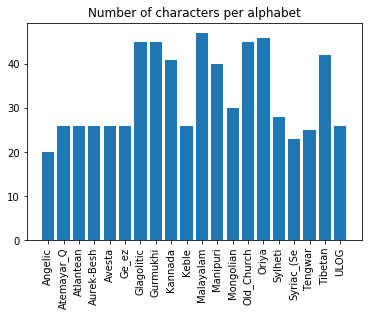


The maximum number of different character for one alphabet is 47
The minimum number of different character for one alphabet is 20
The total number of different character is 659


In [15]:
alph_num_char_test ={alphabet:len(os.listdir(f'{PATH_TEST}{alphabet}')) for alphabet in alph_type_test}
num_of_char_test = alph_num_char_test.values()

plt.bar(range(len(alph_type_test)),num_of_char_test)
plt.xticks(range(len(alph_type_test)), [alph[:10] for alph in alph_type_test], rotation=90)
plt.title('Number of characters per alphabet')
plt.show()

print(f'\nThe maximum number of different character for one alphabet is {max(num_of_char_test)}')
print(f'The minimum number of different character for one alphabet is {min(num_of_char_test)}')
total_char_test = sum(num_of_char_test)
print(f'The total number of different character is {total_char_test}')

### 2.Number of pictures per character
#### a) Training set

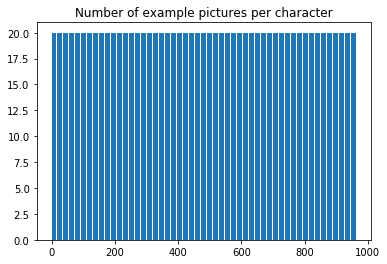

20 20
The total number of different pictures is 19280


In [22]:
alph_num_char_ex={}
for alphabet in alph_type:
    char_list=os.listdir(f'{PATH}{alphabet}')
    for char in char_list:
        alph_num_char_ex[(alphabet,char)]= len(os.listdir(f'{PATH}{alphabet}/{char}'))

num_of_example = alph_num_char_ex.values()

plt.bar(range(len(alph_num_char_ex)),num_of_example)
plt.title('Number of example pictures per character')
plt.show()

total_example = sum(num_of_example) 
print(min(num_of_example),max(num_of_example))
print(f'The total number of different pictures is {total_example}')

#### b) Evaluation set

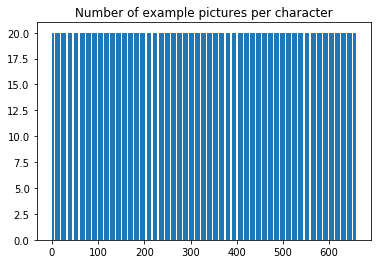

20 20
The total number of different pictures is 13180


In [21]:
alph_num_char_ex_test={}
for alphabet in alph_type_test:
    char_list_test=os.listdir(f'{PATH_TEST}{alphabet}')
    for char in char_list_test:
        alph_num_char_ex_test[(alphabet,char)]= len(os.listdir(f'{PATH_TEST}{alphabet}/{char}'))

num_of_example_test = alph_num_char_ex_test.values()

plt.bar(range(len(alph_num_char_ex_test)),num_of_example_test)
plt.title('Number of example pictures per character')
plt.show()

total_example = sum(num_of_example_test) 
print(min(num_of_example_test),max(num_of_example_test))
print(f'The total number of different pictures is {total_example}')

We can observe that each character have 20 examples(pictures) and that our training and evluation set are well balanced. For our training we will consider that each character is an independent class.

## C/ Preprocessing

### 1.Add a label for each character


For each picture in our training set we set a corresponding integer which allow us to determine the corresponding character. Here an integer is sufficient as we are not really interested in knowing from which alphabet an image is coming from and as we don't have need to know the character name.

In [6]:
Y_train = np.array([i//20+1 for i in range(total_example)])
Y_train.shape

(19280,)

We reshape, our data to have the number of channel including (here is 1).

In [7]:
Y_train=Y_train.reshape(*Y_train.shape,1)
Y_train.shape

(19280, 1)

### 2.Convert images to datafile

We first retrieve the path for each picture in the dataset.

In [8]:
#Train set
imagePath = glob.glob(f"{PATH}*/*/*.png")

#Test set
testPath = glob.glob(f"{PATH_TEST}*/*/*.png")

imagePath[0:5]

['images_background/Syriac_(Estrangelo)/character17/0289_20.png',
 'images_background/Syriac_(Estrangelo)/character17/0289_08.png',
 'images_background/Syriac_(Estrangelo)/character17/0289_12.png',
 'images_background/Syriac_(Estrangelo)/character17/0289_17.png',
 'images_background/Syriac_(Estrangelo)/character17/0289_05.png']

#### A few examples

We print some random images of the dataset, convert them to arrays and resize them.
We decide to resize to the size of 64x64 pixels, which will help the model to be easier to train. Moreover, 64x64 seems a reasonable size still allowing us and the machine to recognize the character.

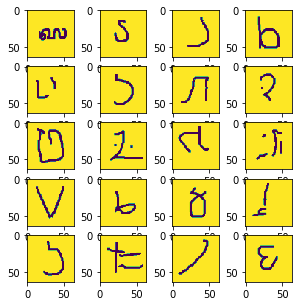

In [9]:
SZ=64 #Dimension of the output image expected

#Dimensions of the grill of sample pictures
columns = 4
rows = 5

fig=plt.figure(figsize=(5, 5))

#Print 20 random examples of images
list_example = np.random.randint(total_example, size = columns*rows)
pos=0
for i in list_example:
    pos+=1
    img = mpimg.imread(imagePath[i])
    img = resize(img, (SZ,SZ), mode='reflect')
    fig.add_subplot(rows, columns, pos)
    plt.imshow(img)
plt.show()

All images seems clear and well centered. We can also observe that they only have one channel and no RGB.

#### Image conversion
We convert all training images into arrays and resize them all to the 64x64 format. We concatenate all arrays into the variable X_train

#### a) Training set

In [23]:
#Train set
#Transform in array and resize all 19280 images 
X_train = np.array([resize(mpimg.imread(i), (SZ,SZ), mode='nearest') for i in imagePath] )
X_train.shape

NameError: name 'imagePath' is not defined

In our CNN blocks later we will need to define a number of channel. Here pictures only have one channel. So we will reshape the pictures to take in account that they have one channel.

In [11]:
channel_sz = 1 #number of channel
X_train= X_train.reshape(*X_train.shape, channel_sz)
X_train.shape

(19280, 64, 64, 1)

#### b) Evaluation set

The same process is done with the evaluation set

In [12]:
test_array = np.array([resize(mpimg.imread(i), (SZ,SZ), mode='nearest') for i in testPath] )
test_array= test_array.reshape(*test_array.shape, channel_sz)
test_array.shape

(13180, 64, 64, 1)

In [13]:
class_char_test = np.array([i//20+1 for i in range(test_array.shape[0])])
class_char_test = class_char_test.reshape(*class_char_test.shape,1)
class_char_test.shape

(13180, 1)

### 3. Validation/Test set split


We split the evaluation set into a train and a validation sets of pictures (Test : 70%, Validation : 30%)
We will use the validation set to select our model and the test set to check the performance of our model.

In [14]:
X_val, X_test, Y_val, Y_test = train_test_split(test_array, class_char_test, test_size=0.7, stratify= class_char_test)
X_val.shape, X_test.shape, Y_val.shape, Y_test.shape

((3954, 64, 64, 1), (9226, 64, 64, 1), (3954, 1), (9226, 1))

### 4.Triplet loss function

Our loss function is determined by the following triplet loss function.<br/>
The basic idea here is to take the embeddings of a triplet of pictures (Anchor, Positive, Negative) where :
* Anchor :  are the embeddings corresponding to our base image
* Positive : are the embeddings of another image corresponding to the same class as our Anchor 
* Negative : are the embeddings of an image which correspond to an image from a different class than our Anchor

The goal of the triplet loss is to minimize the distance between the embeddings of the Anchor and the Positive image (that we call the pos_dist), while it should maximize the distance between the embeddings of the Anchor and the Negative Image(neg_dist).
Thus triplet loss should maximize the difference between the pos_dis and neg_dis. If this difference if below 0, our model is accurate, while if the difference is above 0, we obtain a value for our loss to optimize.


Due to the way we define our triplet_loss we need to add an alpha term to insure that the difference between pos_dist and neg_dist is not zero. This also prevent the model from choosing the trivial values of zero embeddings for our 3 images.

The initial triplet loss is define as the sum of the difference between pos_dist and neg_dist over a mini-batch. Therefore it makes the loss value dependant of the mini batc size. Instead we choose to use the mean over a minibatch to keep a constant loss independent of mini batch size.
We also decide to divide by alpha to obtain a value non dependent of alpha.

In [30]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 64)
            positive -- the encodings for the positive images, of shape (None, 64)
            negative -- the encodings for the negative images, of shape (None, 64)
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[:,0:64], y_pred[:,64:128], y_pred[:,128:196]
    
    #Compute the (encoding) distance between the anchor and the positive, you will need to sum over axis=-1
    pos_dist = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis = -1))
    #Compute the (encoding) distance between the anchor and the negative, you will need to sum over axis=-1
    neg_dist = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis = -1))
    #Subtract the two previous distances and add alpha.
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
    # Count number of positive triplets (where triplet_loss > 0)
    valid_triplets = tf.to_float(tf.greater(basic_loss,0))
    num_positive_triplets = tf.reduce_sum(valid_triplets)
    #Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.reduce_mean(tf.maximum(basic_loss, 0))/ alpha * 100
    
    return loss

We define our error rate by calculating the number of hard triplets over the total number of triplets. For the accuracy we simply take 1-error percentage.

In [24]:
def triplet_acc(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet accuracy
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 64)
            positive -- the encodings for the positive images, of shape (None, 64)
            negative -- the encodings for the negative images, of shape (None, 64)
    
    Returns:
    loss -- real number, value of the accuracy
    """
    
    anchor, positive, negative = y_pred[:,0:64], y_pred[:,64:128], y_pred[:,128:196]
    
    #Compute the (encoding) distance between the anchor and the positive, you will need to sum over axis=-1
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis = -1)
    #Compute the (encoding) distance between the anchor and the negative, you will need to sum over axis=-1
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis = -1)
    #Subtract the two previous distances and add alpha.
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
    # Count number of positive triplets (where triplet_loss > 0)
    hard_triplets = tf.to_float(tf.greater(basic_loss,alpha))
    num_hard_triplets = tf.reduce_sum(hard_triplets)
    #Count number of triplets
    all_triplets = tf.reduce_sum(tf.to_float(tf.greater(basic_loss,-10**10)))
    
    #Accuracy
    acc = 1 - num_hard_triplets/all_triplets
    
    return acc

### 5.Creation of valid triplets

The possible number of valid triplets in our training set is huge:
20*19*19XXX

To be able to feed our model with only valid triplets, we will later build a generator for our training set based on a select. Therefore for the validation set, to be able to compare more accurately our models, we create a fixed number of valid triplets. There is no need here to create a generator as all the triplets can easily fit in memory.
For each (anchor, positive) couple of images we add a random negative anchor image.

In [18]:
def create_triplets(X, Y, num=1):
    """
    Create a list of valid triplets for each valid (anchor, positive) couple
    
    Arguments:
    X -- array of images
    Y -- array of classes corresponding to each image
    num -- number of negative images for each valid anchor and positive images - must be positive
           if num = 0, all possible valid couples are created
            For example : for one valid (A,P) couple we can select 'num' random N images. 
                          Thus 'num' triplets are created for this (A,P) couple
    
    Returns:
    (A,P,N) -- python tuple containing 3 arrays : 
            A -- the array for the anchor images, of shape (None, 64)
            P -- the array for the positive images, of shape (None, 64)
            N -- the array for the negative images, of shape (None, 64)
    """

    Y = Y.reshape(Y.shape[0],)
    A = []
    P = []
    N = []
    
    #We loop over all possible valid (A,P)
    for i in range(X.shape[0]):  
        list_pos = X[Y==Y[i]]
        for j in list_pos:
            #We provide a number 'num' of triplets for each valid (A,P)
            if num >=1:
                for k in range(num):
                    rand_num = np.random.randint(X.shape[0])
                    if np.array_equal(X[i],j) == False:
                        A.append(X[i])
                        P.append(j)
                        while np.array_equal(Y[rand_num], Y[i]):
                            rand_num = np.random.randint(X.shape[0])
                        N.append(X[rand_num])
            if num == 0:
                for k in range(X.shape[0]):
                    if np.array_equal(X[i],j) == False:
                        if np.array_equal(Y[i],Y[k]) == False:
                            A.append(X[i])
                            P.append(j)
                            N.append(X[k])
    
    A = np.array(A)
    P = np.array(P)
    N = np.array(N)
    
    return (A, P, N)

In [20]:
triplets_list_val = create_triplets(X_val, Y_val)
print([i.shape for i in triplets_list_val])

[(19770, 64, 64, 1), (19770, 64, 64, 1), (19770, 64, 64, 1)]


This gives us a number of 19770 valid triplets for the validation set.

## D/ Triplet loss Neural Network architecture

The Triplet loss Neural Network is composed of 2 parts :
* a Convolutional Neural Network(CNN) which transforms an input image into an embedding(vector of features describing the whale). The same CNN, with the same weights are used one valid triplet of images.
* a global model which will concatenante all the embeddings

### 1.Embedding Model

The embedding model that we use is based on the version 2 of ResNet model. Therefore we won't use the original model because our input images here are only of size 64x64 instead of (229x229) and moreover as our problem is easier with less channels and features we will create a small variant of this model.

The embedding Model is composed of 4 blocks :
* Block 1 - 64x64
* Block 2 - 32x32
* Block 3 - 16x16
* Block 4 - 8x8

In [22]:
def EmbModel(input_shape, l2):
    regul  = regularizers.l2(l2)
    kwargs = {'padding':'same', 'kernel_regularizer':regul,'kernel_initializer':'he_normal'}

    inp = Input(input_shape) # 64x64x1
    x   = Conv2D(32, (3,3), strides=1, **kwargs)(inp) #32x32x64
    x   = BatchNormalization()(x)
    x   = Activation('relu')(x)
    
    #Stage 0 / resblock 0
    y   = Conv2D(32, (1,1), strides=1, **kwargs)(x)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(32, (3,3), strides=1, **kwargs)(y)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(64, (1,1), strides=1, **kwargs)(y)
    
    x   = Conv2D(64, (1,1), strides=1, **kwargs) (x)
    x   = Add()([x,y])
    
    #Stage 0 / resblock 1
    x   = BatchNormalization()(x)
    x   = Activation('relu')(x)
    y   = Conv2D(32, (1,1), strides=1, **kwargs)(x)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(32, (3,3), strides=1, **kwargs)(y)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(64, (1,1), strides=1, **kwargs)(y)
    
    x   = Add()([x,y])
    
    #Stage 1 / resblock 0
    y   = Conv2D(64, (1,1), strides=2, **kwargs)(x)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(64, (3,3), strides=1, **kwargs)(y)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(128, (1,1), strides=1, **kwargs)(y)
    
    x   = Conv2D(128, (1,1), strides=2, **kwargs) (x)
    x   = Add()([x,y])
    
    #Stage 1 / resblock 1
    x   = BatchNormalization()(x)
    x   = Activation('relu')(x)
    y   = Conv2D(64, (1,1), strides=1, **kwargs)(x)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(64, (3,3), strides=1, **kwargs)(y)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(128, (1,1), strides=1, **kwargs)(y)
    
    x   = Add()([x,y])
    
    #Stage 2 / resblock 0
    y   = Conv2D(128, (1,1), strides=2, **kwargs)(x)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(128, (3,3), strides=1, **kwargs)(y)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(256, (1,1), strides=1, **kwargs)(y)
    
    x   = Conv2D(256, (1,1), strides=2, **kwargs) (x)
    x   = Add()([x,y])
    
    #Stage 2 / resblock 1
    x   = BatchNormalization()(x)
    x   = Activation('relu')(x)
    y   = Conv2D(128, (1,1), strides=1, **kwargs)(x)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(128, (3,3), strides=1, **kwargs)(y)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(256, (1,1), strides=1, **kwargs)(y)
    
    x   = Add()([x,y])
    
    #Stage 3 / resblock 0
    y   = Conv2D(256, (1,1), strides=2, **kwargs)(x)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(256, (3,3), strides=1, **kwargs)(y)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(512, (1,1), strides=1, **kwargs)(y)
    
    x   = Conv2D(512, (1,1), strides=2, **kwargs) (x)
    x   = Add()([x,y])
    
    #Stage 2 / resblock 1
    x   = BatchNormalization()(x)
    x   = Activation('relu')(x)
    y   = Conv2D(256, (1,1), strides=1, **kwargs)(x)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(256, (3,3), strides=1, **kwargs)(y)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(512, (1,1), strides=1, **kwargs)(y)
    
    x   = Add()([x,y])
    
    #Final
    x   = BatchNormalization()(x)
    x   = Activation('relu')(x)
    x   = AveragePooling2D(pool_size=8)(x)
    x   = Flatten()(x)
    x = Dense (64, activation ='tanh',kernel_initializer='he_normal') (x)

    
    ##Create model
    model = Model(inputs = inp, outputs = x, name='EmbModel')
    
    return model

### 2.Global model

In [23]:
#We define our global model
def global_model(size, channel_size=1, l2=1e-4):
    input_size = (size, size, channel_sz)                     

    A = Input(input_size)
    P = Input(input_size)
    N = Input(input_size)

    emb_model= EmbModel(input_size, l2)

    out_A = emb_model(A)
    out_P = emb_model(P)
    out_N = emb_model(N)

    y_pred = concatenate([out_A, out_P, out_N], axis =-1)

    full_model = Model(inputs = [A, P, N], outputs = y_pred)
    
    return full_model, emb_model

We create an instance of our model

In [25]:
classification_model, emb_model = global_model(SZ,channel_sz, l2=1e-3)

In [26]:
classification_model.summary()
emb_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
EmbModel (Model)                (None, 64)           2401728     input_1[0][0]                    
                                                                 input_2[0][0]                    
          

### 3.Batch Generator
Before creating our Batch Generator we will create an Image augmentation Pipeline to create more randomness in our data and to reduce overfitting.
#### a) Image Augmentation Pipeline
In our Augmentation Pipeline, we will use the following 4 transformations :
1. random_rotation with a range of 30 degrees
2. random_shear with an intensity of 0.2
3. random_soom with a range of [0.85,1.15]
4. random_shift with a range of 0.15 horizontally as vertically
All these range are selected to be in a 'human range'. That means that they give some approximations of the variation that a human can have when writing these characters

In [27]:
from keras.preprocessing.image import random_rotation, random_shift, random_shear, random_zoom

def augmentation_pipeline(img_arr):
    img_arr = random_rotation(img_arr, 30, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest')
    img_arr = random_shear(img_arr, intensity=0.2, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest')
    img_arr = random_zoom(img_arr, zoom_range=(0.85, 1.15), row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest')
    img_arr = random_shift(img_arr, wrg=0.15, hrg=0.15,fill_mode='nearest')
    return img_arr

#### b)Batch generator

We create a batch generator that will take 'batch_size' valid triplets from an input of images

In [28]:
def batch_generator(X,Y, bs=32,hardmode = False):
    """
    Create a mini-batch generator
    
    Arguments:
    X -- array of images
    Y -- array of classes corresponding to each image
    bs -- size of the minibatch

    
    Returns:
    [A_batch, P_batch, N_batch], y_dummie) -- a mini-batch of size bs
    """
    Y = Y.reshape(Y.shape[0],)
    while True:
        #0. Initialize Anchor,Postive, Negative
        A_batch = []
        P_batch = []
        N_batch = []
        for i in range(bs) :
            #1.Choose a random Anchor Image
            rand_A_num = np.random.randint(X.shape[0])    

            #2.Choose a random Positive Image
            list_pos = X[Y==Y[rand_A_num]]                            #List of positive images
            rand_P_num = np.random.randint(len(list_pos))
            while np.array_equal(X[rand_A_num],list_pos[rand_P_num]):
                rand_P_num = np.random.randint(len(list_pos))
                

            #3.Choose a random Negative Image
            rand_N_num = np.random.randint(X.shape[0])
            while np.array_equal(Y[rand_N_num], Y[rand_A_num]):
                rand_A_num = np.random.randint(X.shape[0])
                
            A_augment = augmentation_pipeline(X[rand_A_num])
            P_augment = augmentation_pipeline(list_pos[rand_P_num])
            N_augment = augmentation_pipeline(X[rand_N_num])
                    
            A_batch.append(A_augment)
            P_batch.append(P_augment)
            N_batch.append(N_augment)
            
        A_batch = np.array(A_batch)
        P_batch = np.array(P_batch)
        N_batch = np.array(N_batch)
        
        y_dummie = np.zeros((len(A_batch),))
        
        yield ([A_batch, P_batch, N_batch], y_dummie)

## E/Training procedure

### 1.Model Training

Regarding the model training we will use a mix of several techniques to optimize our training accuracy and speed :
* Adam optimizer :
* Reduce Learning Rate on Plateau
* Stochastic Gradient Descent with Restart

In [34]:
#Full network 1/32 - Embeddings 64 - Maxout
A_val, P_val, N_val = triplets_list_val
zeros_vect_val = np.zeros(A_val[:,1,1].shape) 


batch_sz = 32


for num in range(1, 10):
    model_name = 'TANH32-%01d.h5' % num
    print(model_name)
    
    #We create a checkpoint to save the best model and add an early stopping
    checkpoint = ModelCheckpoint(model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
    lr_annealing = ReduceLROnPlateau(monitor='val_loss', patience = 3, epsilon=0.01, factor = 0.25, min_lr = 1e-6, verbose = 1, mode='min' )
    callbacks_list = [checkpoint, early_stop, lr_annealing]
    

    #We compile our model with the custom made triplet_loss
    classification_model.compile(optimizer = 'adam', loss = triplet_loss, metrics =[triplet_acc])
    
    classification_model.fit_generator(batch_generator(X_train, Y_train, batch_sz, hardmode=False), 
                                   steps_per_epoch = 550,
                                   epochs = 200,
                                   verbose = 1,
                                   validation_data = ([A_val, P_val, N_val], zeros_vect_val),
                                   callbacks = callbacks_list,
                                  )

TANH32-1.h5
Epoch 1/200
550/550 [==============================] - 187s 341ms/step - loss: 16.6291 - triplet_acc: 0.9692 - val_loss: 74.1449 - val_triplet_acc: 0.7997

Epoch 00001: val_loss improved from inf to 74.14487, saving model to TANH32-1.h5
Epoch 2/200
550/550 [==============================] - 176s 320ms/step - loss: 15.3093 - triplet_acc: 0.9730 - val_loss: 107.9700 - val_triplet_acc: 0.5620

Epoch 00002: val_loss did not improve
Epoch 3/200
550/550 [==============================] - 176s 320ms/step - loss: 14.1778 - triplet_acc: 0.9747 - val_loss: 16.9408 - val_triplet_acc: 0.9662

Epoch 00003: val_loss improved from 74.14487 to 16.94080, saving model to TANH32-1.h5
Epoch 4/200
550/550 [==============================] - 175s 319ms/step - loss: 12.9151 - triplet_acc: 0.9772 - val_loss: 12.3717 - val_triplet_acc: 0.9797

Epoch 00004: val_loss improved from 16.94080 to 12.37169, saving model to TANH32-1.h5
Epoch 5/200
550/550 [==============================] - 175s 318ms/step -

Epoch 76/200
550/550 [==============================] - 206s 375ms/step - loss: 4.0010 - triplet_acc: 0.9959 - val_loss: 5.3199 - val_triplet_acc: 0.9911

Epoch 00076: val_loss improved from 5.32135 to 5.31995, saving model to TANH32-1.h5
Epoch 77/200
550/550 [==============================] - 195s 355ms/step - loss: 4.0996 - triplet_acc: 0.9953 - val_loss: 101.1303 - val_triplet_acc: 0.5775

Epoch 00077: val_loss did not improve
Epoch 78/200
550/550 [==============================] - 217s 394ms/step - loss: 4.0121 - triplet_acc: 0.9961 - val_loss: 5.3153 - val_triplet_acc: 0.9911

Epoch 00078: val_loss improved from 5.31995 to 5.31532, saving model to TANH32-1.h5
Epoch 79/200
550/550 [==============================] - 206s 374ms/step - loss: 4.0338 - triplet_acc: 0.9958 - val_loss: 6.6662 - val_triplet_acc: 0.9867

Epoch 00079: val_loss did not improve
Epoch 80/200
550/550 [==============================] - 209s 379ms/step - loss: 4.0262 - triplet_acc: 0.9956 - val_loss: 5.3156 - val_


Epoch 00046: val_loss did not improve
Epoch 47/200
550/550 [==============================] - 175s 318ms/step - loss: 3.2832 - triplet_acc: 0.9963 - val_loss: 4.7529 - val_triplet_acc: 0.9914

Epoch 00047: val_loss improved from 4.92298 to 4.75291, saving model to TANH32-2.h5
Epoch 48/200
550/550 [==============================] - 175s 318ms/step - loss: 3.3237 - triplet_acc: 0.9960 - val_loss: 4.7305 - val_triplet_acc: 0.9915

Epoch 00048: val_loss improved from 4.75291 to 4.73049, saving model to TANH32-2.h5
Epoch 49/200
550/550 [==============================] - 175s 318ms/step - loss: 3.5032 - triplet_acc: 0.9953 - val_loss: 101.5633 - val_triplet_acc: 0.6030

Epoch 00049: val_loss did not improve
Epoch 50/200
550/550 [==============================] - 175s 318ms/step - loss: 3.3573 - triplet_acc: 0.9961 - val_loss: 4.6730 - val_triplet_acc: 0.9914

Epoch 00050: val_loss improved from 4.73049 to 4.67301, saving model to TANH32-2.h5
Epoch 51/200
550/550 [===========================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



550/550 [==============================] - 175s 318ms/step - loss: 3.2086 - triplet_acc: 0.9963 - val_loss: 4.4830 - val_triplet_acc: 0.9918

Epoch 00078: val_loss improved from 4.48314 to 4.48297, saving model to TANH32-2.h5
Epoch 79/200
550/550 [==============================] - 176s 320ms/step - loss: 3.2232 - triplet_acc: 0.9961 - val_loss: 102.2424 - val_triplet_acc: 1.0000

Epoch 00079: val_loss did not improve
Epoch 80/200
550/550 [==============================] - 175s 318ms/step - loss: 3.1925 - triplet_acc: 0.9969 - val_loss: 4.4813 - val_triplet_acc: 0.9915

Epoch 00080: val_loss improved from 4.48297 to 4.48127, saving model to TANH32-2.h5
Epoch 81/200
550/550 [==============================] - 175s 318ms/step - loss: 3.0962 - triplet_acc: 0.9969 - val_loss: 4.4803 - val_triplet_acc: 0.9915

Epoch 00081: val_loss improved from 4.48127 to 4.48031, saving model to TANH32-2.h5
Epoch 82/200
550/550 [==============================] - 174s 317ms/step - loss: 3.2602 - triplet_acc:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



550/550 [==============================] - 175s 318ms/step - loss: 3.3164 - triplet_acc: 0.9958 - val_loss: 102.2387 - val_triplet_acc: 1.0000

Epoch 00090: val_loss did not improve
Epoch 91/200
550/550 [==============================] - 175s 318ms/step - loss: 3.2078 - triplet_acc: 0.9965 - val_loss: 76.6091 - val_triplet_acc: 0.7899

Epoch 00091: val_loss did not improve
Epoch 92/200
550/550 [==============================] - 175s 318ms/step - loss: 3.2779 - triplet_acc: 0.9964 - val_loss: 4.4649 - val_triplet_acc: 0.9921

Epoch 00092: val_loss improved from 4.47296 to 4.46486, saving model to TANH32-2.h5
Epoch 93/200
550/550 [==============================] - 175s 318ms/step - loss: 2.9709 - triplet_acc: 0.9972 - val_loss: 102.2377 - val_triplet_acc: 1.0000

Epoch 00093: val_loss did not improve
Epoch 94/200
550/550 [==============================] - 175s 319ms/step - loss: 3.1579 - triplet_acc: 0.9966 - val_loss: 4.4752 - val_triplet_acc: 0.9916

Epoch 00094: val_loss did not impro

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



550/550 [==============================] - 175s 318ms/step - loss: 3.1744 - triplet_acc: 0.9967 - val_loss: 87.9087 - val_triplet_acc: 0.7376

Epoch 00104: val_loss did not improve
Epoch 105/200
550/550 [==============================] - 176s 320ms/step - loss: 3.3261 - triplet_acc: 0.9958 - val_loss: 44.4433 - val_triplet_acc: 0.8591

Epoch 00105: val_loss did not improve
Epoch 106/200
550/550 [==============================] - 175s 318ms/step - loss: 3.1468 - triplet_acc: 0.9965 - val_loss: 4.4594 - val_triplet_acc: 0.9918

Epoch 00106: val_loss did not improve
Epoch 00106: early stopping
TANH32-3.h5
Epoch 1/200
550/550 [==============================] - 188s 342ms/step - loss: 5.7770 - triplet_acc: 0.9867 - val_loss: 13.4658 - val_triplet_acc: 0.9630

Epoch 00001: val_loss improved from inf to 13.46578, saving model to TANH32-3.h5
Epoch 2/200
550/550 [==============================] - 176s 320ms/step - loss: 6.7799 - triplet_acc: 0.9841 - val_loss: 74.3112 - val_triplet_acc: 0.6890


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



550/550 [==============================] - 176s 320ms/step - loss: 6.5893 - triplet_acc: 0.9866 - val_loss: 17.0338 - val_triplet_acc: 0.9497

Epoch 00011: val_loss did not improve
Epoch 12/200
550/550 [==============================] - 176s 320ms/step - loss: 6.1605 - triplet_acc: 0.9887 - val_loss: 102.4558 - val_triplet_acc: 0.5989

Epoch 00012: val_loss did not improve
Epoch 13/200
550/550 [==============================] - 176s 319ms/step - loss: 6.3226 - triplet_acc: 0.9878 - val_loss: 103.2271 - val_triplet_acc: 1.0000

Epoch 00013: val_loss did not improve
Epoch 14/200
550/550 [==============================] - 175s 318ms/step - loss: 6.6786 - triplet_acc: 0.9868 - val_loss: 8.8490 - val_triplet_acc: 0.9808

Epoch 00014: val_loss did not improve

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 15/200
550/550 [==============================] - 176s 319ms/step - loss: 5.5142 - triplet_acc: 0.9907 - val_loss: 9.4288 - val_triplet_acc: 0.9784



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



550/550 [==============================] - 176s 319ms/step - loss: 3.9480 - triplet_acc: 0.9952 - val_loss: 71.9395 - val_triplet_acc: 0.7498

Epoch 00025: val_loss did not improve
Epoch 26/200
550/550 [==============================] - 175s 318ms/step - loss: 3.7793 - triplet_acc: 0.9956 - val_loss: 5.2544 - val_triplet_acc: 0.9912

Epoch 00026: val_loss did not improve
Epoch 27/200
550/550 [==============================] - 175s 319ms/step - loss: 4.0282 - triplet_acc: 0.9948 - val_loss: 5.2560 - val_triplet_acc: 0.9909

Epoch 00027: val_loss did not improve
Epoch 28/200
550/550 [==============================] - 176s 320ms/step - loss: 3.9646 - triplet_acc: 0.9951 - val_loss: 5.2401 - val_triplet_acc: 0.9911

Epoch 00028: val_loss improved from 5.24525 to 5.24008, saving model to TANH32-3.h5
Epoch 29/200
550/550 [==============================] - 176s 319ms/step - loss: 3.8452 - triplet_acc: 0.9961 - val_loss: 5.1984 - val_triplet_acc: 0.9912

Epoch 00029: val_loss improved from 5.2

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



550/550 [==============================] - 175s 319ms/step - loss: 3.9740 - triplet_acc: 0.9949 - val_loss: 102.6024 - val_triplet_acc: 1.0000

Epoch 00038: val_loss did not improve
Epoch 39/200
550/550 [==============================] - 176s 319ms/step - loss: 3.8281 - triplet_acc: 0.9954 - val_loss: 13.6023 - val_triplet_acc: 0.9590

Epoch 00039: val_loss did not improve
Epoch 40/200
550/550 [==============================] - 175s 319ms/step - loss: 3.7004 - triplet_acc: 0.9960 - val_loss: 5.1064 - val_triplet_acc: 0.9909

Epoch 00040: val_loss improved from 5.16138 to 5.10644, saving model to TANH32-3.h5
Epoch 41/200
550/550 [==============================] - 175s 318ms/step - loss: 3.8021 - triplet_acc: 0.9952 - val_loss: 6.4139 - val_triplet_acc: 0.9868

Epoch 00041: val_loss did not improve
Epoch 42/200
550/550 [==============================] - 175s 318ms/step - loss: 3.9306 - triplet_acc: 0.9951 - val_loss: 102.5995 - val_triplet_acc: 1.0000

Epoch 00042: val_loss did not impro

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



550/550 [==============================] - 176s 320ms/step - loss: 3.6363 - triplet_acc: 0.9959 - val_loss: 5.0936 - val_triplet_acc: 0.9913

Epoch 00051: val_loss did not improve
Epoch 52/200
550/550 [==============================] - 174s 317ms/step - loss: 3.9543 - triplet_acc: 0.9948 - val_loss: 102.5953 - val_triplet_acc: 1.0000

Epoch 00052: val_loss did not improve
Epoch 53/200
550/550 [==============================] - 175s 318ms/step - loss: 3.8331 - triplet_acc: 0.9957 - val_loss: 5.0898 - val_triplet_acc: 0.9912

Epoch 00053: val_loss did not improve
Epoch 54/200
550/550 [==============================] - 175s 317ms/step - loss: 3.8352 - triplet_acc: 0.9951 - val_loss: 5.1171 - val_triplet_acc: 0.9913

Epoch 00054: val_loss did not improve
Epoch 55/200
550/550 [==============================] - 175s 319ms/step - loss: 3.6934 - triplet_acc: 0.9961 - val_loss: 5.0892 - val_triplet_acc: 0.9912

Epoch 00055: val_loss did not improve
Epoch 56/200
487/550 [========================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



550/550 [==============================] - 175s 318ms/step - loss: 5.7067 - triplet_acc: 0.9889 - val_loss: 7.5374 - val_triplet_acc: 0.9826

Epoch 00005: val_loss did not improve
Epoch 6/200
550/550 [==============================] - 175s 319ms/step - loss: 5.7981 - triplet_acc: 0.9886 - val_loss: 8.1719 - val_triplet_acc: 0.9802

Epoch 00006: val_loss did not improve
Epoch 7/200
550/550 [==============================] - 175s 318ms/step - loss: 5.4855 - triplet_acc: 0.9895 - val_loss: 6.3886 - val_triplet_acc: 0.9874

Epoch 00007: val_loss improved from 6.82811 to 6.38860, saving model to TANH32-4.h5
Epoch 8/200
550/550 [==============================] - 176s 319ms/step - loss: 5.5718 - triplet_acc: 0.9894 - val_loss: 87.8187 - val_triplet_acc: 0.7950

Epoch 00008: val_loss did not improve
Epoch 9/200
550/550 [==============================] - 175s 319ms/step - loss: 5.4985 - triplet_acc: 0.9898 - val_loss: 7.5564 - val_triplet_acc: 0.9837

Epoch 00009: val_loss did not improve
Epoch

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



550/550 [==============================] - 176s 320ms/step - loss: 3.8362 - triplet_acc: 0.9937 - val_loss: 33.2070 - val_triplet_acc: 0.8897

Epoch 00018: val_loss did not improve
Epoch 19/200
550/550 [==============================] - 175s 319ms/step - loss: 3.8010 - triplet_acc: 0.9944 - val_loss: 59.0015 - val_triplet_acc: 0.7705

Epoch 00019: val_loss did not improve
Epoch 20/200
550/550 [==============================] - 176s 321ms/step - loss: 3.8356 - triplet_acc: 0.9939 - val_loss: 4.8812 - val_triplet_acc: 0.9904

Epoch 00020: val_loss improved from 5.08247 to 4.88120, saving model to TANH32-4.h5
Epoch 21/200
550/550 [==============================] - 176s 319ms/step - loss: 3.4155 - triplet_acc: 0.9951 - val_loss: 102.1819 - val_triplet_acc: 1.0000

Epoch 00021: val_loss did not improve
Epoch 22/200
550/550 [==============================] - 176s 320ms/step - loss: 3.4896 - triplet_acc: 0.9950 - val_loss: 4.8977 - val_triplet_acc: 0.9902

Epoch 00022: val_loss did not improv

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



550/550 [==============================] - 176s 320ms/step - loss: 3.1237 - triplet_acc: 0.9958 - val_loss: 101.9065 - val_triplet_acc: 1.0000

Epoch 00031: val_loss did not improve
Epoch 32/200
550/550 [==============================] - 174s 317ms/step - loss: 2.8903 - triplet_acc: 0.9961 - val_loss: 101.8931 - val_triplet_acc: 1.0000

Epoch 00032: val_loss did not improve
Epoch 33/200
550/550 [==============================] - 175s 319ms/step - loss: 3.0285 - triplet_acc: 0.9957 - val_loss: 4.1810 - val_triplet_acc: 0.9917

Epoch 00033: val_loss improved from 4.23617 to 4.18101, saving model to TANH32-4.h5
Epoch 34/200
550/550 [==============================] - 177s 321ms/step - loss: 2.9069 - triplet_acc: 0.9957 - val_loss: 101.8685 - val_triplet_acc: 1.0000

Epoch 00034: val_loss did not improve
Epoch 35/200
550/550 [==============================] - 178s 323ms/step - loss: 2.9096 - triplet_acc: 0.9959 - val_loss: 4.1651 - val_triplet_acc: 0.9917

Epoch 00035: val_loss improved fro

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



550/550 [==============================] - 176s 319ms/step - loss: 2.8208 - triplet_acc: 0.9960 - val_loss: 3.9646 - val_triplet_acc: 0.9921

Epoch 00041: val_loss improved from 4.12509 to 3.96464, saving model to TANH32-4.h5
Epoch 42/200
550/550 [==============================] - 175s 318ms/step - loss: 2.6642 - triplet_acc: 0.9968 - val_loss: 5.1948 - val_triplet_acc: 0.9873

Epoch 00042: val_loss did not improve
Epoch 43/200
550/550 [==============================] - 176s 320ms/step - loss: 2.7585 - triplet_acc: 0.9964 - val_loss: 67.3021 - val_triplet_acc: 0.7442

Epoch 00043: val_loss did not improve
Epoch 44/200
550/550 [==============================] - 176s 320ms/step - loss: 2.5807 - triplet_acc: 0.9972 - val_loss: 101.7586 - val_triplet_acc: 1.0000

Epoch 00044: val_loss did not improve
Epoch 45/200
550/550 [==============================] - 176s 320ms/step - loss: 2.6425 - triplet_acc: 0.9965 - val_loss: 101.7454 - val_triplet_acc: 1.0000

Epoch 00045: val_loss did not impro

550/550 [==============================] - 176s 320ms/step - loss: 2.8298 - triplet_acc: 0.9960 - val_loss: 4.3648 - val_triplet_acc: 0.9903

Epoch 00028: val_loss did not improve
Epoch 29/200
550/550 [==============================] - 176s 320ms/step - loss: 2.7637 - triplet_acc: 0.9965 - val_loss: 4.3546 - val_triplet_acc: 0.9905

Epoch 00029: val_loss did not improve
Epoch 30/200
550/550 [==============================] - 184s 334ms/step - loss: 2.5683 - triplet_acc: 0.9970 - val_loss: 94.0531 - val_triplet_acc: 0.7104

Epoch 00030: val_loss did not improve

Epoch 00030: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 00030: early stopping
TANH32-6.h5
Epoch 1/200
550/550 [==============================] - 199s 362ms/step - loss: 4.5300 - triplet_acc: 0.9897 - val_loss: 15.8859 - val_triplet_acc: 0.9507

Epoch 00001: val_loss improved from inf to 15.88593, saving model to TANH32-6.h5
Epoch 2/200
550/550 [==============================] - 181s 330ms/step - loss: 4.7050 - trip

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



550/550 [==============================] - 182s 331ms/step - loss: 2.4483 - triplet_acc: 0.9973 - val_loss: 74.5225 - val_triplet_acc: 0.8042

Epoch 00052: val_loss did not improve
Epoch 53/200
550/550 [==============================] - 183s 332ms/step - loss: 2.5493 - triplet_acc: 0.9972 - val_loss: 101.7455 - val_triplet_acc: 1.0000

Epoch 00053: val_loss did not improve
Epoch 54/200
550/550 [==============================] - 183s 332ms/step - loss: 2.6081 - triplet_acc: 0.9966 - val_loss: 3.8522 - val_triplet_acc: 0.9923

Epoch 00054: val_loss improved from 3.85557 to 3.85221, saving model to TANH32-6.h5
Epoch 55/200
550/550 [==============================] - 181s 328ms/step - loss: 2.7565 - triplet_acc: 0.9963 - val_loss: 3.8564 - val_triplet_acc: 0.9921

Epoch 00055: val_loss did not improve
Epoch 56/200
550/550 [==============================] - 184s 334ms/step - loss: 2.4597 - triplet_acc: 0.9970 - val_loss: 72.5512 - val_triplet_acc: 0.7884

Epoch 00056: val_loss did not improv

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



550/550 [==============================] - 177s 322ms/step - loss: 2.6999 - triplet_acc: 0.9963 - val_loss: 7.4497 - val_triplet_acc: 0.9778

Epoch 00059: val_loss did not improve
Epoch 60/200
550/550 [==============================] - 184s 334ms/step - loss: 2.4925 - triplet_acc: 0.9975 - val_loss: 101.7441 - val_triplet_acc: 1.0000

Epoch 00060: val_loss did not improve
Epoch 61/200
550/550 [==============================] - 181s 328ms/step - loss: 2.7400 - triplet_acc: 0.9963 - val_loss: 3.8515 - val_triplet_acc: 0.9922

Epoch 00061: val_loss improved from 3.85221 to 3.85147, saving model to TANH32-6.h5
Epoch 62/200
550/550 [==============================] - 184s 334ms/step - loss: 2.7100 - triplet_acc: 0.9964 - val_loss: 101.7438 - val_triplet_acc: 1.0000

Epoch 00062: val_loss did not improve
Epoch 63/200
550/550 [==============================] - 181s 328ms/step - loss: 2.6838 - triplet_acc: 0.9963 - val_loss: 42.6572 - val_triplet_acc: 0.8319

Epoch 00063: val_loss did not impro

550/550 [==============================] - 176s 320ms/step - loss: 4.1653 - triplet_acc: 0.9919 - val_loss: 101.9719 - val_triplet_acc: 1.0000

Epoch 00010: val_loss did not improve

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11/200
550/550 [==============================] - 179s 326ms/step - loss: 3.5556 - triplet_acc: 0.9941 - val_loss: 97.8362 - val_triplet_acc: 0.7667

Epoch 00011: val_loss did not improve
Epoch 12/200
550/550 [==============================] - 177s 322ms/step - loss: 3.0912 - triplet_acc: 0.9951 - val_loss: 101.5858 - val_triplet_acc: 0.5739

Epoch 00012: val_loss did not improve
Epoch 13/200
550/550 [==============================] - 178s 324ms/step - loss: 3.0587 - triplet_acc: 0.9955 - val_loss: 100.3080 - val_triplet_acc: 0.7073

Epoch 00013: val_loss did not improve

Epoch 00013: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 14/200
550/550 [==============================] - 178s 323ms/step -

KeyboardInterrupt: 

### 2.Model Selection

We selected the model with the best validation loss

In [52]:
global_loss=1e9
A_val, P_val, N_val = triplets_list_val
zeros_vect_val = np.zeros(A_val[:,1,1].shape) 

for weights in ['TANH32-1.h5','TANH32-2.h5','TANH32-3.h5','TANH32-4.h5','TANH32-5.h5','TANH32-6.h5','TANH32-7.h5','TANH32-8.h5']:
    classification_model.load_weights(weights)
    loss, acc = classification_model.evaluate([A_val, P_val, N_val], zeros_vect_val, batch_size=32, verbose=0)
    print(weights, loss, acc)
    if (loss<global_loss):
        model_name = weights
        global_loss = loss
        
classification_model.load_weights(model_name)
model_name, global_loss

19770/19770 [==============================] - 43s 2ms/step
TANH32-1.h5 5.294122102396863 0.9912999493821317
19770/19770 [==============================] - 43s 2ms/step
TANH32-2.h5 4.429839496101221 0.9920586747235581
19770/19770 [==============================] - 43s 2ms/step
TANH32-3.h5 5.077177170834037 0.9918563480020233
19770/19770 [==============================] - 43s 2ms/step
TANH32-4.h5 3.7348441636254828 0.9921092564129865
19770/19770 [==============================] - 44s 2ms/step
TANH32-5.h5 4.339544625250933 0.9912493676927033
19770/19770 [==============================] - 44s 2ms/step
TANH32-6.h5 3.84008408043803 0.9923621648963076
19770/19770 [==============================] - 45s 2ms/step
TANH32-7.h5 5.768011224975354 0.9852807283401489
19770/19770 [==============================] - 44s 2ms/step
TANH32-8.h5 97.51743054233178 0.7675265553990095


('TANH32-4.h5', 3.7348441636254828)

In [47]:
classification_model.load_weights('TANH32-4.h5')

#### Final Model Ensemble

In [54]:
def final_emb(emb_model, item):
    classification_model.load_weights('TANH32-2.h5')
    emb1 = emb_model.predict_on_batch(item)
    
    classification_model.load_weights('TANH32-4.h5')
    emb2 = emb_model.predict_on_batch(item)
    
    classification_model.load_weights('TANH32-6.h5')
    emb3 = emb_model.predict_on_batch(item)
    
    emb = np.mean([emb1,emb2,emb3],axis = 0)
    
    return emb

### 3.Model Evaluation

#### Comparison with Modified Hausdorff Distance

In [48]:
from demo_classification import *

In [49]:
def CNNDistance(itemA, itemB):
    """
    Compute the euclidean distance between the embeddings of the two images. 
    The embeddings have been calculated by using the emb_model.
    
    Arguments:
    itemA -- array of images
    itemB -- array of images
    
    Returns:
    dist - euclidean distance
    """
    
    itemA = itemA.reshape(1, itemA.shape[0], itemA.shape[1], 1)
    itemB = itemB.reshape(1, itemB.shape[0], itemB.shape[1], 1)
    itemA_emb = emb_model.predict_on_batch(itemA)
    itemB_emb = emb_model.predict_on_batch(itemB)
    dist = np.linalg.norm(itemA_emb - itemB_emb) #2-norm by default
    return dist

In [50]:
def LoadImgAsArray(fn):
    """
    Load an image file, resize it and return an array
    
    Arguments:
    fn -- an image
    
    Returns:
    image -- an array of image 
    """
    picture = mpimg.imread(fn)
    image = resize(picture, (SZ,SZ), mode='nearest')
    return image

We then calculate the error rate by comparing ModHausdhorff Distance with our Embeddings triplet loss Distance

In [41]:
#tanh32-4
print ('One-shot classification with Modified Hausdorff Distance versus embeddings triplet loss Distance')
perror = np.zeros(nrun)
perror_cnn =np.zeros(nrun)
for r in range(1,nrun+1):
	rs = str(r)
	if len(rs)==1:
		rs = '0' + rs		
	perror[r-1] = classification_run('one-shot-classification','/run'+rs, LoadImgAsPoints, ModHausdorffDistance, 'cost')
	perror_cnn[r-1] = classification_run('one-shot-classification','run'+rs, LoadImgAsArray, CNNDistance, 'cost')
	print (" run " + str(r) + " ModHausdorffDistance" + "(error " + str(	perror[r-1] ) + "%)"+ "  -  Embeddings_triplet_loss_Distance" + " (error " + str(	perror_cnn[r-1] ) + "%)")		
total = np.mean(perror)
total_cnn = np.mean(perror_cnn)
print (" average error ModHausdorffDistance " + str(total) + "%" + "  average error Embeddings_triplet_loss_Distance " + str(total_cnn) + "%")

One-shot classification with Modified Hausdorff Distance versus Siamese triplet loss Distance
 run 1 ModHausdorffDistance(error 45.0%)  -  Siamese_triplet_loss_Distance (error 15.0%)
 run 2 ModHausdorffDistance(error 35.0%)  -  Siamese_triplet_loss_Distance (error 5.0%)
 run 3 ModHausdorffDistance(error 40.0%)  -  Siamese_triplet_loss_Distance (error 0.0%)
 run 4 ModHausdorffDistance(error 25.0%)  -  Siamese_triplet_loss_Distance (error 5.0%)
 run 5 ModHausdorffDistance(error 30.0%)  -  Siamese_triplet_loss_Distance (error 20.0%)
 run 6 ModHausdorffDistance(error 15.0%)  -  Siamese_triplet_loss_Distance (error 0.0%)
 run 7 ModHausdorffDistance(error 60.0%)  -  Siamese_triplet_loss_Distance (error 0.0%)
 run 8 ModHausdorffDistance(error 35.0%)  -  Siamese_triplet_loss_Distance (error 10.0%)
 run 9 ModHausdorffDistance(error 40.0%)  -  Siamese_triplet_loss_Distance (error 0.0%)
 run 10 ModHausdorffDistance(error 55.0%)  -  Siamese_triplet_loss_Distance (error 5.0%)
 run 11 ModHausdorffDi

#### Error on the test set

In [ ]:
20 way classification


def nway(num_way, num_run):
    """
    Create a N way classification
    """
    
    choice_classes np.random.rand()

How to improve the model :
Bayesian optimization

In [ ]:

    def make_oneshot_task(N,s="val"):
        """Create pairs of test image, support set for testing N way one-shot learning.
        
        Arguments :
        N -- Number of different characters
        """
        X=self.data[s]
        n_classes, n_examples, w, h = X.shape
        indices = rng.randint(0,n_examples,size=(N,))
        if language is not None:
            low, high = self.categories[s][language]
            if N > high - low:
                raise ValueError("This language ({}) has less than {} letters".format(language, N))
            categories = rng.choice(range(low,high),size=(N,),replace=False)
            
        else:#if no language specified just pick a bunch of random letters
            categories = rng.choice(range(n_classes),size=(N,),replace=False)            
        true_category = categories[0]
        ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
        test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
        support_set = X[categories,indices,:,:]
        support_set[0,:,:] = X[true_category,ex2]
        support_set = support_set.reshape(N, w, h,1)
        targets = np.zeros((N,))
        targets[0] = 1
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        pairs = [test_image,support_set]

        return pairs, targets
    
    def test_oneshot(self,model,N,k,s="val",verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        if verbose:
            print("Evaluating model on {} random {} way one-shot learning tasks ...".format(k,N))
        for i in range(k):
            inputs, targets = self.make_oneshot_task(N,s)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy".format(percent_correct,N))
        return percent_correct

In [ ]:
def test_nn_accuracy(N_ways,n_trials,loader):
    """Returns accuracy of one shot """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = loader.make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials


ways = np.arange(1, 60, 2)
resume =  False
val_accs, train_accs,nn_accs = [], [], []
trials = 450
for N in ways:
    val_accs.append(loader.test_oneshot(siamese_net, N,trials, "val", verbose=True))
    train_accs.append(loader.test_oneshot(siamese_net, N,trials, "train", verbose=True))
    nn_accs.append(test_nn_accuracy(N,trials, loader))
    
#plot the accuracy vs num categories for each
plt.plot(ways, val_accs, "m")
plt.plot(ways, train_accs, "y")
plt.plot(ways, nn_accs, "c")

plt.plot(ways,100.0/ways,"r")
plt.show()